# Predict Future Sales 

Kaggle: https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data

The main goal of this kaggle competition is to predict the monthly sales for the next month based on the historical daily sales of each store and each product for 34 months. In other words, we use historical sales to predict future sales. Therefore, it's a time-series problem.

Project difficulties: 
1. Data is scattered in multiple excel files
2. Predictors are not suitable for direct use and require more feature engineering
3. The information brought by the time series should be fully exploited


Evaluation method:
Submissions are evaluated by root mean squared error (RMSE). True target values are clipped into [0,20] range.

#### File descriptions:
sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.

test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.

sample_submission.csv - a sample submission file in the correct format.

items.csv - supplemental information about the items/products.

item_categories.csv  - supplemental information about the items categories.

shops.csv- supplemental information about the shops.
#### Data fields
ID - an Id that represents a (Shop, Item) tuple within the test set

shop_id - unique identifier of a shop

item_id - unique identifier of a product

item_category_id - unique identifier of item category

item_cnt_day - number of products sold. You are predicting a monthly amount of this measure

item_price - current price of an item

date - date in format dd/mm/yyyy

date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

item_name - name of item

shop_name - name of shop

item_category_name - name of item category

### Step 1: Read main training csv file

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pylab as plt

In [2]:
df = pd.read_csv(r'C:\kaggle\sales_train.csv')

In [3]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


### Step 2: Drop duplicates

In [4]:
df.drop_duplicates(keep='first', inplace=True)

### Step 3: Check whether there is missing value

In [5]:
df.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

The answer is no. Therefore, we don't need to do imputation here.

### Step 4:  Extract feature 'month' from date
In the raw data, sales volume represents daily sales volume. In our prediction target, the sales volume refers to the monthly sales volume, so we need to make some adjustments.  In addition, the month and season greatly affect the sales of some products, so we extract new information from the month here, in order to further carry out feature engineer later.

In [6]:
def date_month(time):
    day, month, year = time.split('.')
    #If require complete datetime type columns, use the following comment
    #return datetime.datetime(int(year),int(month),int(day))
    return int(month)
df['month'] = list(map(date_month, df['date']))

In [7]:
df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month
0,02.01.2013,0,59,22154,999.00,1.0,1
1,03.01.2013,0,25,2552,899.00,1.0,1
2,05.01.2013,0,25,2552,899.00,-1.0,1
3,06.01.2013,0,25,2554,1709.05,1.0,1
4,15.01.2013,0,25,2555,1099.00,1.0,1
...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,10
2935845,09.10.2015,33,25,7460,299.00,1.0,10
2935846,14.10.2015,33,25,7459,349.00,1.0,10
2935847,22.10.2015,33,25,7440,299.00,1.0,10


In [8]:
df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,month
count,2.935843e+06,2.935843e+06,2.935843e+06,2.935843e+06,2.935843e+06,2.935843e+06
mean,1.456991e+01,3.300171e+01,1.019723e+04,8.908535e+02,1.242641e+00,6.247719e+00
std,9.422992e+00,1.622698e+01,6.324293e+03,1.729801e+03,2.618837e+00,3.536219e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,1.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,3.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,6.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,9.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,1.200000e+01


In [9]:
col = df.drop('date', axis=1).columns
col

Index(['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day',
       'month'],
      dtype='object')

In [10]:
df = df[col].groupby(["item_id", "shop_id", "date_block_num"]).agg({'item_price': 'mean', 'month': 'mean', 'item_cnt_day': 'sum'}).reset_index()
df.rename(columns={"item_cnt_day": "item_cnt_month"}, inplace=True)
df

,item_id,shop_id,date_block_num,item_price,month,item_cnt_month
0,0,54,20,58.0,9,1.0
1,1,55,15,4490.0,4,2.0
2,1,55,18,4490.0,7,1.0
3,1,55,19,4490.0,8,1.0
4,1,55,20,4490.0,9,1.0
...,...,...,...,...,...,...
1609119,22168,12,8,799.0,9,1.0
1609120,22168,16,1,799.0,2,1.0
1609121,22168,42,1,799.0,2,1.0
1609122,22168,43,2,798.5,3,1.0


### Step 5: Visualization

In this section, we use visualization to show the relationship of our montly sales(target variable) over time.

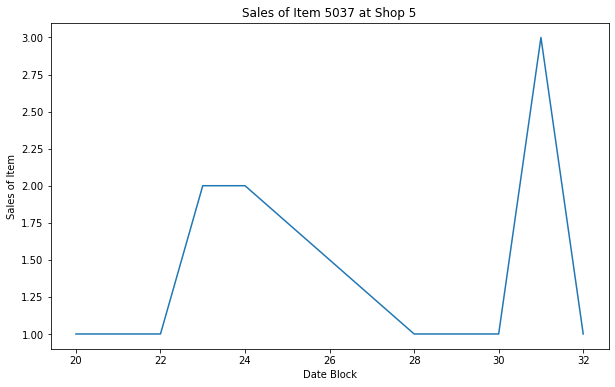

In [11]:
check = df.loc[(df['shop_id'] == 5) & (df['item_id'] == 5037)]
plt.figure(figsize=(10, 6))
plt.title('Sales of Item 5037 at Shop 5')
plt.xlabel('Date Block')
plt.ylabel('Sales of Item')
plt.plot(check['date_block_num'], check['item_cnt_month'])

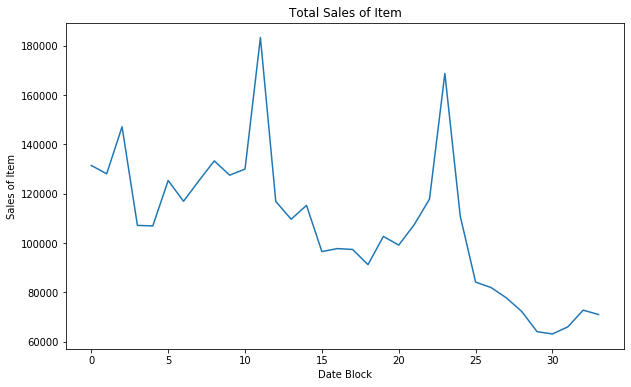

In [12]:
from matplotlib import pylab as plt
check = df[['date_block_num', 'item_cnt_month']].groupby(["date_block_num"]).sum().reset_index()
plt.figure(figsize=(10, 6))
plt.title('Total Sales of Item')
plt.xlabel('Date Block')
plt.ylabel('Sales of Item')
plt.plot(check['date_block_num'], check['item_cnt_month'])

We can see that the monthly sales volume has an obvious trend of change. Moreover, sales seem to rise and fall periodically. Therefore, I think season may be the reason of this cycle. We created a new variable "season".

In [13]:
df['season'] = None
df['season'].loc[(df['month'] >= 2) & (df['month'] <= 4)] = 1
df['season'].loc[(df['month'] >= 5) & (df['month'] <= 7)] = 2
df['season'].loc[(df['month'] >= 8) & (df['month'] <= 10)] = 3
df['season'].loc[(df['month'] == 11) | (df['month'] == 12) | (df['month'] == 1)] = 4

C:\Users\10039\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


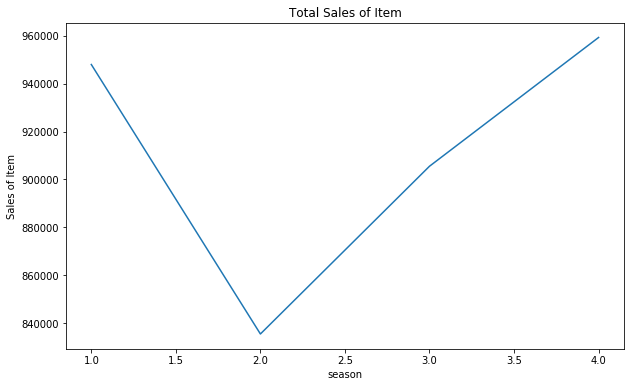

In [14]:
check = df[['season', 'item_cnt_month']].groupby(["season"]).sum().reset_index()
plt.figure(figsize=(10, 6))
plt.title('Total Sales of Item')
plt.xlabel('season')
plt.ylabel('Sales of Item')
plt.plot(check['season'], check['item_cnt_month'])

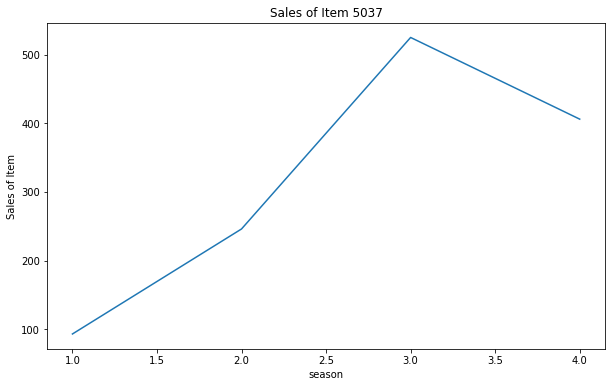

In [15]:
check = df.loc[df['item_id'] == 5037]
check = check[['season', 'item_cnt_month']].groupby(["season"]).sum().reset_index()
plt.figure(figsize=(10,6))
plt.title('Sales of Item 5037')
plt.xlabel('season')
plt.ylabel('Sales of Item')
plt.plot(check['season'], check['item_cnt_month'])

Visualization confirms our conjecture. Season is closely related to sales volume and there is a clear trend. Therefore, we believe that season is beneficial to improve the accuracy of our prediction.

### Step 6: Time-series columns and Imputation

Time series is the key to this kaggle competition, and how to make full use of the historical sales volume is the key for us.

In this case, we're using a violent approach. List the sales of each product in each store for each month. This has great benefits. Previously, we found that sales volume was closely related to month and season through visualization. Listing all the months allows machine learning algorithms to learn and exploit the patterns. There is no need to manually add factors such as season.

In addition, some of the stores in the records had certain items that are not recorded. From the records we can analyze that these goods are not sold at that month. In other words, their monthly sales volume is 0. Therefore, in a practical sense, we should fill in the missing records with 0.

In [16]:
table = df.pivot_table(index=['shop_id', 'item_id'], columns='date_block_num', values='item_cnt_month',aggfunc='sum').fillna(0.0).reset_index()
table['shop_id']= table.shop_id
table['item_id']= table.item_id
df_price = df[['shop_id', 'item_id', 'item_price']].groupby(["item_id", "shop_id"]).mean().reset_index()
df = pd.merge(table, df_price, on=['shop_id', 'item_id'], how='inner')

In [17]:
df

,shop_id,item_id,0,1,2,3,4,5,6,7,...,25,26,27,28,29,30,31,32,33,item_price
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,265.0
1,0,31,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,434.0
2,0,32,6.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,221.0
3,0,33,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,347.0
4,0,35,1.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,247.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424119,59,22154,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,999.0
424120,59,22155,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,149.0
424121,59,22162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,4.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,369.0
424122,59,22164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,724.0


### Step 7: drop outliers
caculate zscore of the average of monthly sales, and drop samples whose average is over 3 or below -3.

Normally, we don't drop outliers of target variable. However, in this case, the problem statement true target values are clipped into [0,20]. And some the target values have extreme high value, which affects our accuracy.

In [18]:
col = df.columns[2:-1]
average = np.mean(df[col], axis=1)

In [19]:
zscore = (average - np.mean(average)) / np.std(average)
drop_index = zscore[(zscore > 3) | (zscore < -3)].index
df.drop(drop_index, axis=0, inplace=True)

### Step 8: create item category feature from item id

The product ID does not provide us with valid information. But I can turn it into categories. The corresponding categories of goods are provided in Kaggle. However, I think the number of categories is too large. Once we do one-hot encoding, the number of our variables increases significantly. Therefore, I further selected some categories manually.

In [20]:
item_category_id = pd.read_csv(r'C:\kaggle\items.csv')
item_category_id

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [21]:
item_category = pd.read_csv(r'C:\kaggle\item_categories.csv')
item_category

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [22]:
df_category = pd.merge(item_category_id, item_category, on=['item_category_id'])
df_category

,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD
...,...,...,...,...
22165,Элемент питания GP 15AU (LR6) - Блистер 2 шт U...,22095,83,Элементы питания
22166,Элемент питания GP 24A (LR03) - Блистер 2 шт,22096,83,Элементы питания
22167,Элемент питания GP 24AU (LR03) - Блистер 2 шт ...,22097,83,Элементы питания
22168,Элемент питания КОСМОС LR03 2*BL,22098,83,Элементы питания


In [23]:
df_category['item_category_id'].astype(np.int32)
df_category['new_item_category'] = 'other'
df_category['new_item_category'].loc[df_category['item_category_id'].between(1, 8, inclusive=True)] = 'Digital Appliances'
df_category['new_item_category'].loc[df_category['item_category_id'].between(10, 18, inclusive=True)] = 'Consoles'
df_category['new_item_category'].loc[df_category['item_category_id'].between(18, 25, inclusive=True)] = 'Consoles Games'
df_category['new_item_category'].loc[df_category['item_category_id'].between(26, 27, inclusive=True)] = 'Phone games'
df_category['new_item_category'].loc[df_category['item_category_id'].between(28, 31, inclusive=True)] = 'CD games'
df_category['new_item_category'].loc[df_category['item_category_id'].between(32, 36, inclusive=True)] = 'Card'
df_category['new_item_category'].loc[df_category['item_category_id'].between(37, 42, inclusive=True)] = 'Movie'
df_category['new_item_category'].loc[df_category['item_category_id'].between(43, 54, inclusive=True)] = 'Books'
df_category['new_item_category'].loc[df_category['item_category_id'].between(55, 60, inclusive=True)] = 'Music'
df_category['new_item_category'].loc[df_category['item_category_id'].between(61, 72, inclusive=True)] = 'Gifts'
df_category['new_item_category'].loc[df_category['item_category_id'].between(73, 79, inclusive=True)] = 'Soft'

(array([8629., 4325., 1777., 2167., 1261., 3528.,   42.,  228.,   11.,
         202.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <a list of 10 Patch objects>)

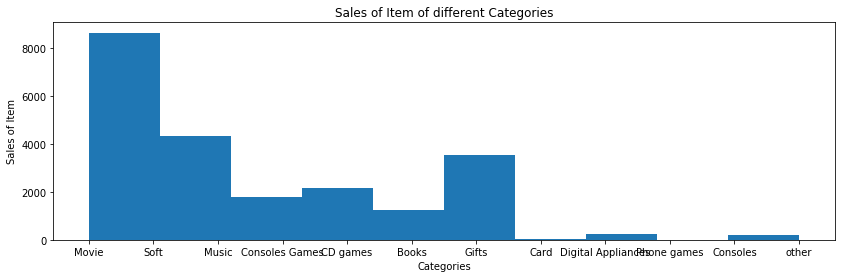

In [24]:
plt.figure(figsize=(14, 4))
plt.title('Sales of Item of different Categories')
plt.xlabel('Categories')
plt.ylabel('Sales of Item')
plt.hist(df_category['new_item_category'])

In [25]:
df = pd.merge(df, df_category[['item_id', 'new_item_category']], on=['item_id'], how='left')
df

,shop_id,item_id,0,1,2,3,4,5,6,7,...,26,27,28,29,30,31,32,33,item_price,new_item_category
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,265.0,Movie
1,0,31,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,434.0,Movie
2,0,32,6.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,221.0,Movie
3,0,33,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,347.0,Movie
4,0,35,1.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,247.0,Movie
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423228,59,22154,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,999.0,Movie
423229,59,22155,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,149.0,Movie
423230,59,22162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,369.0,Movie
423231,59,22164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,724.0,Movie


### Step 9: One-hot Encoding

In [26]:
df_cate = pd.get_dummies(df['new_item_category'], drop_first=True)
df = pd.concat([df, df_cate], axis=1)
df.drop(['new_item_category'], axis=1, inplace=True)
df

,shop_id,item_id,0,1,2,3,4,5,6,7,...,Card,Consoles,Consoles Games,Digital Appliances,Gifts,Movie,Music,Phone games,Soft,other
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,0,31,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
2,0,32,6.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
3,0,33,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
4,0,35,1.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423228,59,22154,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
423229,59,22155,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,1,0,0,0,0
423230,59,22162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
423231,59,22164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0


### Step 10: Standard Scaler

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
col = ['item_price']
df[col] = scaler.fit_transform(df[col])

In [28]:
df

,shop_id,item_id,0,1,2,3,4,5,6,7,...,Card,Consoles,Consoles Games,Digital Appliances,Gifts,Movie,Music,Phone games,Soft,other
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,0,31,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
2,0,32,6.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
3,0,33,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
4,0,35,1.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423228,59,22154,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
423229,59,22155,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,1,0,0,0,0
423230,59,22162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
423231,59,22164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0


### Step 11: Calcuate Correlation Matrix
This step is not necessary, but the correlation matrix helps us to understand the relationship between variables. Since we are using the xgboost, we do not need to add interaction terms.

In [29]:
pd.DataFrame(np.corrcoef(df.T), columns=df.columns, index=df.columns)

,shop_id,item_id,0,1,2,3,4,5,6,7,...,Card,Consoles,Consoles Games,Digital Appliances,Gifts,Movie,Music,Phone games,Soft,other
shop_id,1.000000,0.010923,-0.024771,-0.033838,0.018950,0.026773,0.027990,0.025625,0.032086,0.027501,...,-0.001893,-0.002186,-0.017376,-0.006428,-0.003240,0.021304,0.000686,0.006754,0.003874,-0.005444
item_id,0.010923,1.000000,-0.042663,-0.057309,-0.045205,-0.031248,-0.031501,-0.035140,-0.037043,-0.052491,...,-0.036851,0.003537,-0.382620,-0.096315,0.205112,0.426908,-0.177016,-0.005171,-0.136633,0.026175
0,-0.024771,-0.042663,1.000000,0.476861,0.264419,0.220451,0.185541,0.158598,0.187896,0.147012,...,0.003008,-0.006672,0.014208,0.016303,-0.025099,-0.036809,-0.037073,-0.001094,0.033701,0.095088
1,-0.033838,-0.057309,0.476861,1.000000,0.361899,0.253317,0.177906,0.162527,0.174493,0.162430,...,0.005399,-0.009382,0.019478,0.005936,-0.023580,-0.035396,-0.034157,-0.000985,0.028613,0.068574
2,0.018950,-0.045205,0.264419,0.361899,1.000000,0.466400,0.269678,0.206799,0.240169,0.194610,...,0.003805,-0.010245,0.017937,-0.000646,-0.026864,-0.036057,-0.031986,-0.000924,0.018506,0.052433
3,0.026773,-0.031248,0.220451,0.253317,0.466400,1.000000,0.458061,0.269035,0.272016,0.199550,...,0.006424,-0.011401,0.008192,-0.002139,-0.025790,-0.025786,-0.021971,-0.000981,0.025456,0.068401
4,0.027990,-0.031501,0.185541,0.177906,0.269678,0.458061,1.000000,0.428273,0.361425,0.241030,...,0.005500,-0.011831,0.015555,-0.002873,-0.026753,-0.032000,-0.017233,-0.000966,0.015492,0.075061
5,0.025625,-0.035140,0.158598,0.162527,0.206799,0.269035,0.428273,1.000000,0.542531,0.298521,...,0.010872,-0.009624,0.028633,-0.002310,-0.019861,-0.039912,-0.019175,-0.000987,0.009906,0.074586
6,0.032086,-0.037043,0.187896,0.174493,0.240169,0.272016,0.361425,0.542531,1.000000,0.430448,...,0.010783,-0.009976,0.005548,0.001195,-0.027220,-0.034656,-0.013162,-0.001173,0.015794,0.078076
7,0.027501,-0.052491,0.147012,0.162430,0.194610,0.199550,0.241030,0.298521,0.430448,1.000000,...,0.012291,-0.009554,0.026823,-0.000611,-0.026191,-0.044009,-0.021210,-0.001051,0.009250,0.038304


### Step 12: Hyperparameter Tuning

In [30]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

In [31]:
xgb = XGBRegressor()
parameters = {
              'learning_rate': [0.3, 0.5], 
              'max_depth': [10, 15],
              'subsample': [0.7],
              'n_estimators': [100, 200],
              'eval_metric': ['rmse']}
xgb_grid = GridSearchCV(xgb, parameters, cv=3, n_jobs=-1, verbose=True)

X = df.drop(33, axis=1)
Y = df[33]
xgb_grid.fit(X, Y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 44.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estima...
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=False, verbosity=None),
             iid='deprecated', n_jobs=-1,
             param_grid=

In [32]:
#Here are our optimal hyperparameters
best_grid = xgb_grid.best_estimator_
best_grid

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.3, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method=None, validate_parameters=False, verbosity=None)